In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os.path as osp
from statsmodels.tsa.tsatools import detrend
from scipy.signal import butter, filtfilt, tukey

In [19]:
dual_reg_folder = 'dual_regression_group_melodic_dynFC_100'
timecoure_template = 'dr_stage1_subject{:05}.txt'
num_subj = 75
TR = 2.
FS = 1/TR
nyq = 0.5 * FS
n_vol = 233
n_rsn = 100
window_size = 22
window_stepsize = 1
num_windows = np.floor((n_vol - window_size)/window_stepsize + 1).astype(np.int)

### Post-processing (minimal)

In [12]:
data_all_subj = np.zeros((n_vol, n_rsn, num_subj))
b, a = butter(6, 0.15/nyq, btype='lowpass')

for id_sub in xrange(num_subj):
    data_subj = np.loadtxt(osp.join(dual_reg_folder, timecoure_template.format(id_sub)))
    data_subj = detrend(data_subj, axis=0, order=1)
    data_subj = detrend(data_subj, axis=0, order=2)
    data_subj = detrend(data_subj, axis=0, order=3)
    data_subj = filtfilt(b, a, data_subj, axis=0)
    data_subj = (data_subj - data_subj.mean(axis=0, keepdims=True))/data_subj.std(axis=0, keepdims=True)
    
    data_all_subj[..., id_sub] = data_subj

In [14]:
data_all_subj.shape

(233, 100, 75)

In [38]:
print 'zero mean?', np.allclose(data_all_subj.mean(axis=0), 0)

zero mean? True


In [41]:
print 'var/std=1?', np.allclose(data_all_subj.std(axis=0), 1)

var/std=1? True


### Static FC

In [67]:
cov_static = np.zeros((n_rsn, n_rsn, num_subj))
for i_subj in xrange(num_subj):
    cov_static[:, :, i_subj] = np.cov(data_all_subj[:, :, i_subj], rowvar=False, bias=True)

In [68]:
cov_static.shape

(100, 100, 75)

In [70]:
print cov_static.min(), cov_static.max()

-0.892204566143 1.0


The correct range is only insured when you divide the covariance by N (=233 in my case) instead of N-1 for an unbiased estimate.

### Windowing

In [71]:
w = tukey(M=window_size)

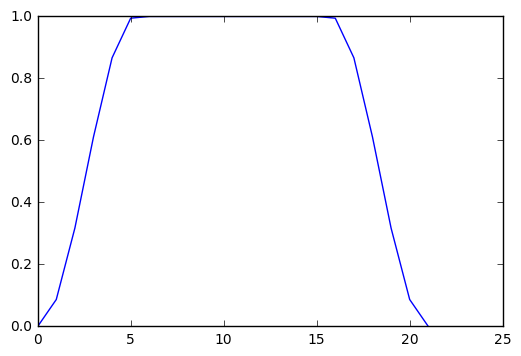

In [72]:
plt.plot(w)

In [73]:
w_broadcasten = w[:, np.newaxis, np.newaxis]

In [78]:
window_timecourses = np.zeros((window_size, num_windows, n_rsn, num_subj))
cov_dynamic = np.zeros((n_rsn, n_rsn, num_windows, num_subj))

for i_window in xrange(0, num_windows, window_stepsize):
    window_timecourses[:, i_window, :, :] = data_all_subj[i_window:(i_window + window_size), :, :] * w_broadcasten
    for i_subj in xrange(num_subj):
        cov_dynamic[:, :, i_window, i_subj] = np.cov(window_timecourses[:, i_window, :, i_subj], rowvar=False, bias=False)

In [79]:
cov_dynamic.shape

(100, 100, 212, 75)

In [80]:
print 'max/min:', cov_dynamic.max(), cov_dynamic.min()

max/min: 5.66808849043 -4.37077826482


But as expected since you normalized the variance across all the time-course (and not for the window) the dynamic covariance estimates are no correlations.

In [81]:
window_timecourses.shape

(22, 212, 100, 75)

### GraphLasso

In [102]:
from sklearn.covariance import GraphLassoCV, GraphLasso
from sklearn.model_selection import KFold

In [88]:
cv = KFold(n_splits=10, shuffle=False)

In [89]:
timecourses_concat = window_timecourses.reshape((np.product(window_timecourses.shape[:2]), 
                                                            window_timecourses.shape[2], 
                                                            window_timecourses.shape[3]), order='F')

In [90]:
timecourses_concat.shape

(4664, 100, 75)

In [99]:
glasso = GraphLassoCV(alphas=50, cv=cv, n_jobs=3, max_iter=200, verbose=1)

In [100]:
glasso.fit(timecourses_concat[:, :, 0])

/home/paul/anaconda2/lib/python2.7/site-packages/sklearn/covariance/graph_lasso_.py:230: RuntimeWarning: invalid value encountered in multiply
  * coefs)
/home/paul/anaconda2/lib/python2.7/site-packages/sklearn/covariance/graph_lasso_.py:232: RuntimeWarning: invalid value encountered in multiply
  * coefs)
/home/paul/anaconda2/lib/python2.7/site-packages/numpy/linalg/linalg.py:1712: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/home/paul/anaconda2/lib/python2.7/site-packages/sklearn/covariance/graph_lasso_.py:230: RuntimeWarning: invalid value encountered in multiply
  * coefs)
/home/paul/anaconda2/lib/python2.7/site-packages/sklearn/covariance/graph_lasso_.py:232: RuntimeWarning: invalid value encountered in multiply
  * coefs)
/home/paul/anaconda2/lib/python2.7/site-packages/numpy/linalg/linalg.py:1712: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signatu

[GraphLassoCV] Done refinement  1 out of 4:  100s


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:  3.4min finished


[GraphLassoCV] Done refinement  2 out of 4:  307s
[GraphLassoCV] Done refinement  3 out of 4:  508s


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:  3.3min finished


[GraphLassoCV] Done refinement  4 out of 4:  706s


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:  3.3min finished
/home/paul/anaconda2/lib/python2.7/site-packages/sklearn/covariance/graph_lasso_.py:252: ConvergenceWarning: graph_lasso: did not converge after 200 iteration: dual gap: 3.667e-02
  ConvergenceWarning)


GraphLassoCV(alphas=50, assume_centered=False,
       cv=KFold(n_splits=10, random_state=None, shuffle=False),
       enet_tol=0.0001, max_iter=200, mode='cd', n_jobs=3, n_refinements=4,
       tol=0.0001, verbose=1)

In [132]:
tmp = GraphLasso(alpha=5., max_iter=200)

In [134]:
tmp.fit(timecourses_concat[:, :, 0])

GraphLasso(alpha=5.0, assume_centered=False, enet_tol=0.0001, max_iter=200,
      mode='cd', tol=0.0001, verbose=False)

In [ ]:
tmp.covariance_

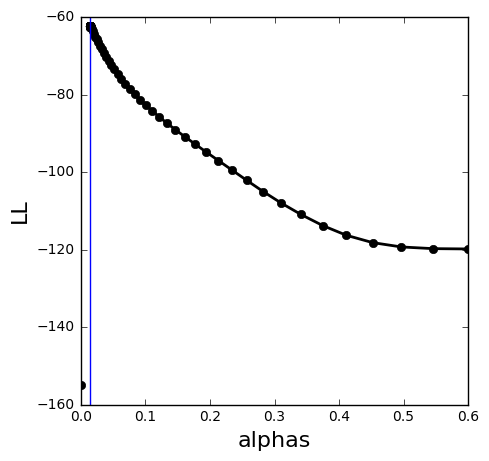

In [129]:
plt.figure(figsize=(5, 5))
plt.plot(np.array(glasso.cv_alphas_), glasso.grid_scores.mean(axis=1), '-ok', lw=2)
plt.xlabel('alphas', fontsize=16)
plt.ylabel('LL', fontsize=16)
plt.axvline(glasso.alpha_)

In [103]:
alpha_best = glasso.alpha_best

In [114]:
from sklearn.covariance import graph_lasso

In [116]:
graph_lasso?

In [112]:
glasso2 = GraphLasso(alpha=alpha_best, mode='lars', max_iter=200, verbose=1)

In [119]:
prec_sparse = np.zeros((n_rsn, n_rsn, num_windows))
cov_sparse = np.zeros_like(prec_sparse)

for i_window in xrange(num_windows):
    X = window_timecourses[:, i_window, :, 0]
    cov, prec = graph_lasso(emp_cov=cov_dynamic[:, :, i_window, 0], alpha=alpha_best, 
                            cov_init=glasso.covariance_, mode='lars',
                            max_iter=200, verbose=100, return_costs=False, return_n_iter=False)
    prec_sparse[:, :, i_iwindow] = prec
    cov_sparse[:, :, i_window] = cov

OverflowError: long int too large to convert to float

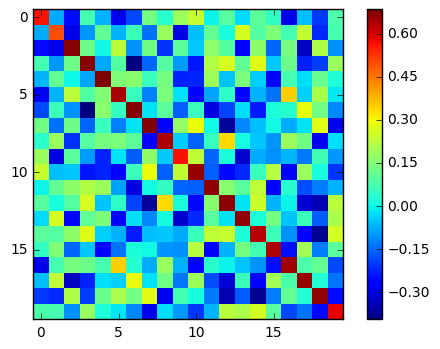

In [113]:
plt.imshow(glasso.covariance_, interpolation='none')
plt.colorbar()

In [122]:
glasso.

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.])